In [ ]:
!pip install gymnasium
!pip install pygame

# Carga y exploración de un entorno de Gymnasium

In [17]:
import gymnasium as gym
import numpy as np
import time
from IPython.display import clear_output, display, HTML
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
from itertools import product
from concurrent.futures import ProcessPoolExecutor, as_completed
import imageio
from IPython.display import HTML

SEED = 42

# -------------------- VISUALIZACIÓN DE RESULTADOS --------------------

def graficar_recompensas(agente):
    """Grafica la recompensa media acumulada por episodio."""
    plt.figure(figsize=(6, 3))
    plt.plot(agente.stats)
    plt.title('Recompensa media acumulada')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa media')
    plt.grid(True)
    plt.show()

def graficar_longitud_episodios(agente):
    """Grafica la longitud de cada episodio."""
    plt.figure(figsize=(6, 3))
    plt.plot(agente.episode_lengths)
    plt.title("Longitud de episodios")
    plt.xlabel("Episodio")
    plt.ylabel("Pasos")
    plt.grid(True)
    plt.show()

def mostrar_resultados_agente_continuo(agente):
    """Muestra gráficos de rendimiento en entornos continuos."""
    graficar_recompensas(agente)
    graficar_longitud_episodios(agente)

# -------------------- EJECUCIÓN DE UN EPISODIO --------------------

def ejecutar_episodio_y_mostrar(agente, render=False):
    """Ejecuta un episodio con la política aprendida y muestra la evolución de la posición."""
    env = agente.env
    state, _ = env.reset()
    done = False
    total_reward = 0
    posiciones = []

    while not done:
        if render:
            env.render()
        posiciones.append(state[0])  # Guardamos la posición del coche
        action = agente._seleccionar_accion(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    env.close()
    
    # Mostrar gráfico de posiciones
    plt.figure(figsize=(6, 3))
    plt.plot(posiciones)
    plt.title("Evolución de la posición del coche")
    plt.xlabel("Paso del episodio")
    plt.ylabel("Posición")
    plt.grid(True)
    plt.show()
    
    print(f"Recompensa total obtenida: {total_reward:.2f}")

# -------------------- VISUALIZACIÓN DE LA POLÍTICA EN EL ESPACIO CONTINUO --------------------

def visualizar_politica_aprendida(agente, resolution=50):
    """Visualiza la política aprendida en el espacio de estados continuo."""
    x = np.linspace(agente.low[0], agente.high[0], resolution)  # posición
    y = np.linspace(agente.low[1], agente.high[1], resolution)  # velocidad
    xx, yy = np.meshgrid(x, y)
    
    policy_map = np.zeros_like(xx)

    for i in range(resolution):
        for j in range(resolution):
            state = np.array([xx[i, j], yy[i, j]])
            policy_map[i, j] = seleccionar_accion_fourier(agente, state)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, policy_map, levels=agente.nA, cmap="coolwarm", alpha=0.8)
    cbar = plt.colorbar(ticks=range(agente.nA))
    cbar.ax.set_yticklabels([f"A{a}" for a in range(agente.nA)])
    plt.xlabel("Posición")
    plt.ylabel("Velocidad")
    plt.title("Política aprendida (acción elegida en cada punto)")
    plt.grid(True)
    plt.show()

# Objeto AgenteSARSA-SemiGradiente

In [7]:
# Tile coder para MountainCar
class TileCoder:
    def __init__(self, low, high, bins=(10, 10), num_tilings=8):
        self.low = np.array(low)
        self.high = np.array(high)
        self.bins = np.array(bins)
        self.num_tilings = num_tilings
        self.tile_width = (self.high - self.low) / (self.bins - 1)
        self.total_tiles = np.prod(self.bins) * num_tilings

        # Crear offsets para cada tiling
        self.offsets = [
            np.random.uniform(0, self.tile_width, size=len(self.low))
            for _ in range(num_tilings)
        ]

    def get_features(self, state):
        features = np.zeros(self.total_tiles)
        for i, offset in enumerate(self.offsets):
            shifted = np.array(state) + offset
            idx = ((shifted - self.low) / self.tile_width).astype(int)
            idx = np.clip(idx, 0, self.bins - 1)
            tile_index = np.ravel_multi_index(idx, self.bins)
            feature_index = i * np.prod(self.bins) + tile_index
            features[int(feature_index)] = 1
        return features



class AgenteSARSATileCoding:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, decay=True, bins=(8, 8), num_tilings=8):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay

        self.nA = env.action_space.n
        self.tile_coder = TileCoder(env.observation_space.low, env.observation_space.high, bins, num_tilings)
        self.d = self.tile_coder.total_tiles
        self.theta = np.zeros((self.nA, self.d))
        self.stats = []
        self.episode_lengths = []

    def _Q(self, state, action):
        phi = self.tile_coder.get_features(state)
        return np.dot(self.theta[action], phi)

    def _seleccionar_accion(self, state):
        """Selecciona una acción usando la política epsilon-soft explícita."""
        policy = self._epsilon_soft_policy(state)
        return np.random.choice(np.arange(self.nA), p=policy)

    def _epsilon_soft_policy(self, state):
        """Devuelve una política epsilon-soft como vector de probabilidades."""
        q_values = np.array([self._Q(state, a) for a in range(self.nA)])
    
        # Reemplazar NaNs o infinitos por 0
        if np.any(np.isnan(q_values)) or np.any(np.isinf(q_values)):
            q_values = np.nan_to_num(q_values)
    
        policy = np.ones(self.nA) * self.epsilon / self.nA
        best_action = np.argmax(q_values)
        policy[best_action] += 1.0 - self.epsilon
    
        # Corrección: asegurar que todas las probabilidades están en [0, 1] y suman 1
        policy = np.clip(policy, 0, 1)
        if policy.sum() == 0:
            policy = np.ones(self.nA) / self.nA
        else:
            policy /= policy.sum()
    
        return policy



    def entrenar(self, num_episodes=5000, mostrar_barra=True):
        from tqdm import tqdm
        acumulador_recompensas = 0.0

        for t in tqdm(range(num_episodes), disable=not mostrar_barra):
            if self.decay:
                self.epsilon = max(0.05, 1000.0 / (t + 1))

            state, _ = self.env.reset(seed=42)
            action = self._seleccionar_accion(state)
            done = False
            total_reward = 0
            pasos = 0

            while not done:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                next_action = self._seleccionar_accion(next_state)

                phi = self.tile_coder.get_features(state)
                q_next = self._Q(next_state, next_action) if not done else 0.0
                q_current = np.dot(self.theta[action], phi)
                target = reward + self.gamma * q_next
                delta = target - q_current

                if not (np.isnan(delta) or np.isinf(delta)):
                    self.theta[action] += self.alpha * delta * phi
                    self.theta[action] = np.clip(self.theta[action], -1e6, 1e6)

                state = next_state
                action = next_action
                total_reward += reward
                pasos += 1

            self.episode_lengths.append(pasos)
            acumulador_recompensas += total_reward
            self.stats.append(acumulador_recompensas / (t + 1))

        return self.theta


In [20]:
def evaluar_configuracion(params, env_name="MountainCar-v0"):
    alpha, gamma, epsilon, decay, num_tilings, bins = params
    env = gym.make(env_name)
    agente = AgenteSARSATileCoding(
        env,
        alpha=alpha,
        gamma=gamma,
        epsilon=epsilon,
        decay=decay,
        num_tilings=num_tilings,
        bins=bins
    )
    agente.entrenar(num_episodes=2000, mostrar_barra=False)
    recompensa_final = np.mean(agente.stats[-100:])  # Media últimos 100 episodios
    return (alpha, gamma, epsilon, decay, num_tilings, bins, recompensa_final)

def random_search(env_name="MountainCar-v0", n_configs=100):
    # Espacios de búsqueda
    alphas = [0.01, 0.05, 0.1]
    gammas = np.linspace(0.8, 1.0, 5)
    epsilons = np.linspace(0.1, 1.0, 5)
    num_tilings_list = [4, 8, 16]
    bins_list = [(4, 4), (6, 6), (8, 8)]
    decays = [True, False]

    # Generar combinaciones aleatorias
    combinaciones = list(product(alphas, gammas, epsilons, decays, num_tilings_list, bins_list))
    np.random.seed(SEED)
    seleccionadas = np.random.choice(len(combinaciones), size=min(n_configs, len(combinaciones)), replace=False)
    combinaciones_random = [combinaciones[i] for i in seleccionadas]

    mejor_config = None
    mejor_recompensa = -float("inf")
    resultados = []

    print("🔍 Ejecutando búsqueda aleatoria de hiperparámetros...\n")

    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(evaluar_configuracion, combo, env_name) for combo in combinaciones_random]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Progreso"):
            alpha, gamma, epsilon, decay, num_tilings, bins, recompensa = future.result()
            resultados.append((alpha, gamma, epsilon, decay, num_tilings, bins, recompensa))

            if recompensa > mejor_recompensa:
                mejor_recompensa = recompensa
                mejor_config = (alpha, gamma, epsilon, decay, num_tilings, bins)

    print("\n✅ Mejor configuración encontrada:")
    print(f" α = {mejor_config[0]}, γ = {mejor_config[1]}, ε = {mejor_config[2]}, decay = {mejor_config[3]}")
    print(f" num_tilings = {mejor_config[4]}, bins = {mejor_config[5]}")
    print(f" → Recompensa media final: {mejor_recompensa:.4f}")

In [21]:
random_search()

🔍 Ejecutando búsqueda aleatoria de hiperparámetros...



Progreso: 100%|████████████████████████████████████████████████████████████████████| 100/100 [3:03:15<00:00, 109.95s/it]


✅ Mejor configuración encontrada:
 α = 0.01, γ = 1.0, ε = 0.1, decay = False
 num_tilings = 8, bins = (8, 8)
 → Recompensa media final: -161.3948


In [22]:
env = gym.make("MountainCar-v0")
agente = AgenteSARSATileCoding(env, alpha=0.01, gamma=1.0, epsilon=0.1, decay=False, bins=(8, 8), num_tilings=8)
agente.entrenar(num_episodes=15000)

100%|█████████████████████████████████████████████████████████████████████████████| 15000/15000 [50:45<00:00,  4.93it/s]


array([[ 0.00000000e+00, -8.67236648e+00, -8.39584794e+00, ...,
         5.01202532e+00,  5.42968516e-04,  0.00000000e+00],
       [ 0.00000000e+00, -7.90616162e+00, -7.49285884e+00, ...,
         5.09696050e+00, -5.11858672e-03,  0.00000000e+00],
       [ 0.00000000e+00, -7.37872320e+00, -5.91417682e+00, ...,
         4.45519105e+00,  2.69443386e-03,  0.00000000e+00]])

# Resultados de agente SARSA SemiGradiente

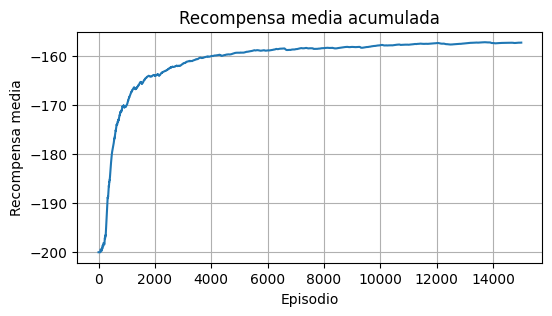

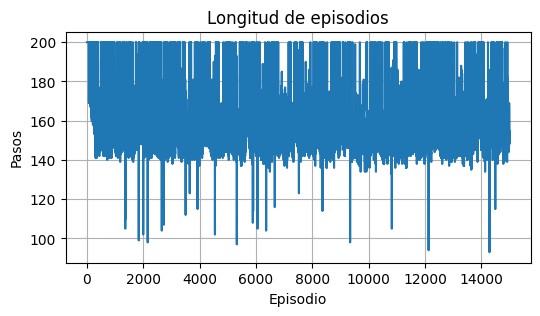

In [23]:
mostrar_resultados_agente_continuo(agente)

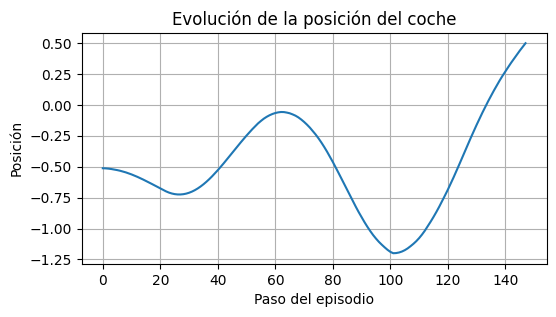

Recompensa total obtenida: -148.00


In [24]:
ejecutar_episodio_y_mostrar(agente)

In [25]:
def grabar_video_agente(agente, nombre_archivo="video_mountaincar.gif", fps=30):
    """
    Ejecuta un episodio con la política aprendida y guarda un video del entorno.
    """
    # Crear entorno con renderizado de imágenes
    env = gym.make("MountainCar-v0", render_mode="rgb_array")
    env.reset(seed=SEED)
    state, _ = env.reset()
    done = False
    total_reward = 0
    frames = []

    while not done:
        frame = env.render()
        frames.append(frame)

        # Acción greedy
        q_values = [agente._Q(state, a) for a in range(agente.nA)]
        action = np.argmax(q_values)

        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        done = terminated or truncated
        state = next_state

        if done:
            break

    env.close()

    print(f"Número total de frames: {len(frames)}")
    # Guardar el video como GIF
    imageio.mimsave(nombre_archivo, frames, fps=fps, loop=0)
    print(f"🎥 Vídeo guardado en: {nombre_archivo}")
    print(f"🏁 Recompensa total obtenida: {total_reward:.2f}")

In [26]:
nombre_archivo = "video_mountaincar_tile_coding.gif"

grabar_video_agente(agente, nombre_archivo=nombre_archivo)

HTML(f"""
<img src="{nombre_archivo}" style="width: 600px;" loop>
""")

Número total de frames: 147
🎥 Vídeo guardado en: video_mountaincar_tile_coding.gif
🏁 Recompensa total obtenida: -147.00
